This notebook is mainly not mine but, I will add some parts to make it like a tutorial for myself, and then |I will change it to test my idea.

Based on: https://towardsdatascience.com/program-a-simple-graph-net-in-pytorch-e00b500a642d

Source: https://github.com/praxidike97/GraphNeuralNet/blob/72c330bb6e64dd7dd6784b6e69a821149dc5d028/main.py#L114

In [3]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 26.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 27.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 25.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 25.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [4]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
import random
random.seed(10)

# what we need

## Graph Class

In [6]:
from itertools import filterfalse
class Graph:
    def __init__(self,nV):
        self.nV = nV
        self.V = list(range(nV))
        self.lenE = 0
        self.VnV = [[] for i in range(nV)]
        self.emV = []
        self.cc = []

    def add_edge(self,v1,v2,directed=False):
        self.VnV[v1].append(v2)
        if not directed:
            self.VnV[v2].append(v1)
        
        self.lenE += 1

    def add_self_loop(self):
        for i in range(self.nV):
            self.VnV[i].append(i)
        self.lenE += self.nV

    def create_embedding(self):
        self.emV = []
        for i in range(self.nV):
            temp = [0 for i in range(self.nV)]
            for j in self.VnV[i]:
                temp[j] = 1
            self.emV.append(temp[:])
        return self.emV
    
    def create_embedding_based_on_input(self,edges):
        self.emboi = np.zeros((self.nV,self.nV))
        for i in range(len(edges[0])):
            self.emboi[edges[0][i]][edges[1][i]] = 1
        return self.emboi

    def create_random_edges(self,index_list,num,avoid_self_loop=False,directed=False):
        for i in range(num):
            e1 = random.choice(index_list)
            e2 = random.choice(index_list)
            if avoid_self_loop:
                while(e2 == e1):
                     e2 = random.choice(index_list)
            self.add_edge(e1,e2,directed=directed)
    
    def clear_redundant_edges(self):
        self.lenE = 0
        for i in range(len(self.VnV)):
            self.VnV[i] = list(set(self.VnV[i]))
            self.lenE += len(self.VnV[i])
            self.lenE += i in self.VnV[i]
        self.lenE/=2

    def ask_nE(self,ifprint=False):
        if ifprint:
            print(int(self.lenE))
        return int(self.lenE)
    
    def edge_index(self):
        E1 = []
        E2 = []
        for i in range(self.nV):
            for j in self.VnV[i]:
                E1.append(i)
                E2.append(j)
        return [E1,E2]

    @staticmethod
    def is_commonelems(x,y):
        for value in x:
            if value in y:
                return True
        return False

    def update_cc(self,index_list):
        self.cc.append(index_list)

    def create_connected_component(self,index_list,nE):
        self.update_cc(index_list)

        n = max(nE-len(index_list)+1,0)
        fill = [index_list[0],index_list[1]]
        self.add_edge(index_list[0],index_list[1])
        for i in range(3,len(index_list)):
            fill.append(index_list[i])
            self.add_edge(index_list[i],random.choice(fill))
        for i in range(n):
            self.add_edge(random.choice(fill),random.choice(fill))

g = Graph(10)
g.add_edge(1,2)
g.add_edge(0,1)
g.add_edge(3,4)
g.create_random_edges(list(range(5,10)),7)
g.add_self_loop()
g.clear_redundant_edges()
g.ask_nE(True)
print(g.edge_index())
g.create_embedding()


18
[[0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 8, 8, 9, 9, 9], [0, 1, 0, 1, 2, 1, 2, 3, 4, 3, 4, 9, 5, 6, 8, 5, 6, 8, 7, 8, 9, 6, 7, 8, 9, 5]]


[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 1]]

# create dataset

In [7]:
class Data:
    def __init__(self,g):
        self.x = np.array(g.create_embedding())
        self.num_node_features = g.nV
        self.edge_index = np.array(g.edge_index())

    def create_mask(self,train_ratio=0.7):
        self.test_mask = []
        self.train_mask = []
        for i in range(len(self.edge_index[0])):
            if random.random()>train_ratio:
                self.test_mask.append(True)
                self.train_mask.append(False)

            else:
                self.train_mask.append(True)
                self.test_mask.append(False)


    def safe_create_mask(self,train_ratio=0.7):
        self.test_mask = []
        self.train_mask = []
        last_train = -1
        for i in range(len(self.edge_index[0])):
            if last_train != self.edge_index[0][i]:
                last_train = self.edge_index[0][i]
                self.train_mask.append(True)
                self.test_mask.append(False)

            elif random.random()>train_ratio:
                self.test_mask.append(True)
                self.train_mask.append(False)
            else:
                self.train_mask.append(True)
                self.test_mask.append(False)



In [8]:
data = Data(g)#g is Graph obj

In [9]:
print(data.num_node_features)
x, edge_index = data.x, data.edge_index
print(x.shape,edge_index.shape)

data.create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

data.safe_create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

10
(10, 10) (2, 26)
18
8
23
3


# test above parts

## not now

### but now:

In [10]:
epoch = 100

In [52]:
g = Graph(10000)
for i in range(100):
    g.create_connected_component(list(range(i*100,i*100+100)),110)

# g.add_self_loop()
g.clear_redundant_edges()
g.ask_nE(True)
# g.create_embedding()

10881


10881

In [53]:
len(g.cc)

100

In [54]:
# g.VnV[:100]

In [55]:
em = g.create_embedding()

In [56]:
data = Data(g)#g is Graph obj

print(data.num_node_features)
x, edge_index = data.x, data.edge_index
print(x.shape,edge_index.shape)

data.create_mask(0.8)
print(sum(data.train_mask))
print(sum(data.test_mask))

# data.safe_create_mask()
# print(sum(data.train_mask))
# print(sum(data.test_mask))

10000
(10000, 10000) (2, 21364)
17085
4279


In [57]:
train = np.array([data.edge_index[0][data.train_mask],data.edge_index[1][data.train_mask]])
test = np.array([data.edge_index[0][data.test_mask],data.edge_index[1][data.test_mask]])

In [58]:
train,test

(array([[   0,    0,    0, ..., 9996, 9997, 9998],
        [   1,    9,   29, ..., 9992, 9942, 9973]]),
 array([[   0,    1,    3, ..., 9993, 9997, 9999],
        [  28,    0,   18, ..., 9907, 9991, 9913]]))

*********************************/////////////////==================================================///////////////////********************************

## find train components again

In [59]:
g2 = Graph(g.nV)
for i in range(len(train[0])):
    g2.add_edge(train[0][i],train[1][i])
g2.clear_redundant_edges()

In [60]:
em = g2.create_embedding()

In [61]:
print(g2.nV,g.nV,g2.lenE)

10000 10000 10399.0


In [62]:
g2.VnV[:100]

[[1, 9, 29, 28, 93],
 [0, 34, 68, 5, 41, 10, 17, 90],
 [],
 [3, 67, 7, 72, 39, 18],
 [4, 36, 44, 79, 20],
 [1, 99, 37, 6, 15, 59],
 [5, 30],
 [3, 70],
 [8, 84],
 [0, 89, 12, 21],
 [1, 13, 14],
 [19],
 [9, 85, 22, 87],
 [24, 33, 10, 56],
 [16, 10, 83],
 [32, 5],
 [32, 85, 14, 23],
 [80, 1, 61, 46],
 [3],
 [42, 11],
 [65, 4, 45, 55],
 [9],
 [26, 27, 12],
 [16, 62, 31],
 [13],
 [25, 98, 60],
 [22, 95],
 [80, 22, 47],
 [0, 43],
 [0, 48],
 [35, 6],
 [58, 23],
 [40, 73, 15, 16, 82, 53, 54, 63],
 [13, 38],
 [1, 66, 76],
 [30],
 [4],
 [91, 5, 86],
 [33],
 [3],
 [32, 60],
 [1, 90],
 [19],
 [28, 94],
 [50, 4],
 [51, 20],
 [17, 97, 71],
 [27],
 [68, 29],
 [49],
 [44],
 [61, 45],
 [],
 [32],
 [32],
 [57, 20],
 [13],
 [61, 55],
 [31],
 [75, 5, 62],
 [40, 25],
 [17, 51, 57],
 [59, 69, 23],
 [32],
 [],
 [20],
 [34],
 [3],
 [48, 1],
 [62],
 [92, 7],
 [78, 46, 95],
 [81, 3],
 [32],
 [74],
 [96, 59],
 [34],
 [],
 [88, 71],
 [4, 84],
 [17, 27],
 [72],
 [32],
 [14],
 [8, 79],
 [16, 12],
 [37],
 [12],
 [78

## find components of train data (g2)

In [63]:
class CGraph:

	# init function to declare class variables
	def __init__(self, V):
		self.V = V
		self.adj = [[] for i in range(V)]

	def DFSUtil(self, temp, v, visited):

		# Mark the current vertex as visited
		visited[v] = True

		# Store the vertex to list
		temp.append(v)

		# Repeat for all vertices adjacent
		# to this vertex v
		for i in self.adj[v]:
			if visited[i] == False:

				# Update the list
				temp = self.DFSUtil(temp, i, visited)
		return temp

	# method to add an undirected edge
	def addEdge(self, v, w):
		self.adj[v].append(w)
		self.adj[w].append(v)

	# Method to retrieve connected components
	# in an undirected graph
	def connectedComponents(self):
		visited = []
		cc = []
		for i in range(self.V):
			visited.append(False)
		for v in range(self.V):
			if visited[v] == False:
				temp = []
				cc.append(self.DFSUtil(temp, v, visited))
		return cc

In [64]:
# Driver Code
cg = CGraph(g2.nV)

for i in tqdm(range(len(train[0]))):
    cg.addEdge(train[0][i],train[1][i])

cc = cg.connectedComponents()


100%|██████████| 17085/17085 [00:02<00:00, 7996.81it/s]


In [65]:
print("# of components: ",len(cc))

temp = []

for i in range(len(cc)):
    # print(i,"--> ",len(cc[i]))
    temp.append(len(cc[i]))


# of components:  629


In [66]:
import matplotlib.pyplot as plt

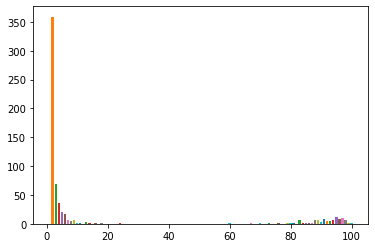

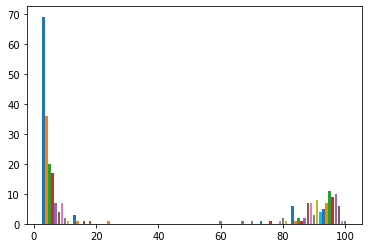

In [67]:
h = np.zeros(100)
for i in temp:
    try:
        h[i]+=1
    except:
        pass
        
ii = 0 
for i in h:
    ii += 1
    plt.bar(ii,i)
plt.show()

ii = 2 
for i in h[2:]:
    ii += 1
    plt.bar(ii,i)
plt.show()

In [68]:
g2.cc = cc

*********************************/////////////////==================================================///////////////////********************************

In [69]:
etrain = g.create_embedding_based_on_input(train)
# etest = g.create_embedding_based_on_input(test)

now we have:

* train: edges
* test: edges
* etrain: matrix

# function for cf and etc.

In [70]:
def edge_convertor(edges):
    temp = []
    for i in range(len(edges[0])):
        temp.append([edges[0][i],edges[1][i]])
    return temp

In [71]:
def negative_sampler(n1,edges,nodes):
    
    n2 = random.choice(nodes)
    while [n1,n2] in edges:
           
        n2 = random.choice(nodes)
    return [n1,n2]

In [113]:
def euclidean_distance(x,y):
    if sum(abs(x))==0 or sum(abs(y))==0:
        return 10
    return sum((x-y)**2)**0.5/(sum(abs(x))*sum(abs(y)))

In [73]:
def distance_ranker(item,l):
    s = 1
    for i in l:
        if item>i:
            s+=1 
    return s

In [74]:
raw_train,raw_test = train[:],test[:]  

#model 1: simple Cf

next phases
* test light_GCN
* test light_GCN with leakage
* test GCN
* test GCN with leakage

# *light_GCN*

In [75]:
etrain.shape

(10000, 10000)

In [76]:
class LGCN:
    def __init__(self):
        pass

    @staticmethod
    def do(inmatrix,VE):
        outmatrix = np.zeros((inmatrix.shape))
        for i, v in enumerate(VE):
            siz = len(v)
            for j in v:
                outmatrix[i]+=inmatrix[j]
            outmatrix[i]/=siz
        return outmatrix

In [77]:
etrain_lgcn = np.copy(etrain)
for i in tqdm(range(epoch)):
    etrain_lgcn = LGCN.do(etrain_lgcn,g.VnV)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


# light_GCN with leakage

In [78]:
class LGCNwL:
    def __init__(self):
        pass
    @staticmethod
    def new_neg_vic(inmatrix,VE,leakageratio,lambdaa,cc):
        for c1 in cc:
             if leakageratio>random.random():
                c2 = random.choice(cc)
                while c2 != c1:
                    c2 = random.choice(cc)
                    
                v1 = random.choice(c1)
                v2 = random.choice(c2)
                temp = inmatrix[v1][:]
                inmatrix[v1] -= lambdaa*inmatrix[v2]
                inmatrix[v2] -= lambdaa*temp
        
        return inmatrix

    @staticmethod
    def do(inmatrix,VE,cc,leakageratio=0.3,lambdaa=0.1):
        outmatrix = np.zeros((inmatrix.shape))
        inmatrix2 = LGCNwL.new_neg_vic(np.copy(inmatrix),VE,leakageratio,lambdaa,cc)
      
        for i, v in enumerate(VE):
            siz = len(v)
            for j in v:
                outmatrix[i]+=inmatrix2[j]
            outmatrix[i]/=siz
        return outmatrix

In [79]:
etrain_lgcnwl = np.copy(etrain)
for i in tqdm(range(epoch)):
    etrain_lgcnwl = LGCNwL.do(etrain_lgcnwl,g2.VnV,g2.cc,leakageratio=0.3,lambdaa=0.1)

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


LGCNwL type 2

In [80]:
class LGCNwL2:
    def __init__(self):
        pass
    @staticmethod
    def new_neg_vic(inmatrix,VE,leakageratio,lambdaa,cc):
        for c1 in range(len(cc)):
             if leakageratio>random.random():
                c2 = random.randint(len(cc))
                while c2 != c1:
                    c2 = random.randint(len(cc))
                    
                v1 = cc(c1)
                v2 = cc(c2)
                vv1 = random.choice(v1)
                vv2 = random.choice(v2)
                temp = inmatrix[vv1]
                temp2 = lambdaa*inmatrix[vv2]
                for v in v1:
                    inmatrix[v] -= lambdaa*temp2
                for v in v2:
                    inmatrix[v] -= lambdaa*temp
        
        return inmatrix

    @staticmethod
    def do(inmatrix,VE,cc,leakageratio=0.3,lambdaa=0.1):
        outmatrix = np.zeros((inmatrix.shape))
        inmatrix2 = LGCNwL.new_neg_vic(np.copy(inmatrix),VE,leakageratio,lambdaa,cc)
      
        for i, v in enumerate(VE):
            siz = len(v)
            for j in v:
                outmatrix[i]+=inmatrix2[j]
            outmatrix[i]/=siz
        return outmatrix

In [81]:
etrain_lgcnwL2 = np.copy(etrain)
for i in tqdm(range(epoch)):
    etrain_lgcnwL2 = LGCNwL2.do(etrain_lgcnwL2,g2.VnV,g2.cc,leakageratio=0.3,lambdaa=0.1)

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


#test phase

##test1

In [82]:
def negative_sampler(n1,edges,nodes):
    n2 = random.choice(nodes)
    while [n1,n2] in edges:  
        n2 = random.choice(nodes)
    return [n1,n2]

In [83]:
def distance_ranker(item,l):
    s = 1
    for i in l:
        if item>=i:
            s+=1 
    return s

In [120]:
def acc_test(raw_train,raw_test,g,g2,etrain):
    print("top1,top3,avg")
    test = edge_convertor(raw_test)
    train = edge_convertor(raw_train)
    tt = test+train
    nodes = g.V
    top1 = 0
    top3 = 0
    avg = 0
    counter_=0
    for sample in tqdm(train[::100]):
        pos = sample
        negs = []
        for i in range(100):
            neg = negative_sampler(pos[0],tt,nodes)
            negs.append(neg)
        dp = euclidean_distance(etrain[pos[0]],etrain[pos[1]])
        dn = [euclidean_distance(etrain[neg[0]],etrain[neg[1]]) for neg in negs]

        r = distance_ranker(dp,dn)
        if r<2:
            top1+=1
        if r<4:
            top3+=1
        avg+=r
        counter_+=1

    print('\ntrain:\n',int(100*top1/len(train[::100])),int(100*top3/len(train[::100])),round(avg/counter_,3))

    top1 = 0
    top3 = 0
    avg = 0
    counter_=0
    for sample in tqdm(test[::5]):
        pos = sample
        negs = []
        for i in range(100):
            neg = negative_sampler(pos[0],tt,nodes)
            negs.append(neg)
        dp = euclidean_distance(etrain[pos[0]],etrain[pos[1]])
        dn = [euclidean_distance(etrain[neg[0]],etrain[neg[1]]) for neg in negs]

        r = distance_ranker(dp,dn)
        if r<2:
            top1+=1
        if r<4:
            top3+=1
        avg+=r
        counter_+=1

    print('\ntest:\n',int(100*top1/len(test[::5])),int(100*top3/len(test[::5])),round(avg/counter_,3))

In [121]:
len(g.V),len(g.edge_index()[0]),len(g.edge_index()[0])/len(g.V)

(10000, 21364, 2.1364)

In [122]:
len(train),len(train[::10]),len(test)

(2, 1, 2)

In [123]:
test

array([[   0,    1,    3, ..., 9993, 9997, 9999],
       [  28,    0,   18, ..., 9907, 9991, 9913]])

In [125]:
print("cf:")
acc_test(raw_train,raw_test,g,g2,etrain)
print("LGCN:")
acc_test(raw_train,raw_test,g,g2,etrain_lgcn)

cf:
top1,top3,avg


100%|██████████| 171/171 [01:15<00:00,  2.26it/s]



train:
 4 9 43.69


100%|██████████| 856/856 [05:15<00:00,  2.71it/s]



test:
 3 5 63.447
LGCN:
top1,top3,avg


100%|██████████| 171/171 [01:19<00:00,  2.15it/s]



train:
 66 97 2.129


100%|██████████| 856/856 [06:43<00:00,  2.12it/s]


test:
 68 97 2.214


In [126]:
print("LGCNwL:")
acc_test(raw_train,raw_test,g,g2,etrain_lgcnwl)
print("LGCNwL2:")
acc_test(raw_train,raw_test,g,g2,etrain_lgcnwL2)

LGCNwL:
top1,top3,avg


100%|██████████| 171/171 [01:21<00:00,  2.11it/s]



train:
 61 91 5.906


100%|██████████| 856/856 [06:49<00:00,  2.09it/s]



test:
 62 88 8.444
LGCNwL2:
top1,top3,avg


100%|██████████| 171/171 [01:22<00:00,  2.07it/s]



train:
 67 90 6.029


100%|██████████| 856/856 [06:46<00:00,  2.11it/s]


test:
 63 88 8.564


In [127]:
len(g.cc),len(g2.cc)

(100, 629)

avg degree: 3.098

train/test: 80%, 20%

\# nodes: 10000

\# components: 100

\# train components: 599

\# negative samples: 10

with self loop

---




*top1,top3,avg*

**cf:**
* train:
 69 83 2.125
* test::
 57 74 2.961

**LGCN:**
* train:
 99 100 1.002
* test::
 99 100 1.001

**LGCNwL:**
* train:
 99 100 1.002
* test:
 92 93 1.818

**LGCNwL2:**
* train:
 99 100 1.001
* test:
 92 93 1.819

 ---
 ---

avg degree: 3.098

train/test: 80%, 20%

\# nodes: 10000

\# connected components: 100

\# train connected components: 599

\# negative samples: 100

with self loop

---




*top1,top3,avg*

**cf:**
* train:
  51 60 11.923
* test::
 89 92 6.703

**LGCN:**
* train:
 98 100 1.012
* test::
 99 100 1.01

**LGCNwL:**
* train:
 98 100 1.016
* test:
 89 92 6.703
 
**LGCNwL2:**
* train:
 99 100 1.008
* test:
 88 92 6.729

 ---
 ---

avg degree: 3.098

train/test: 80%, 20%

\# nodes: 10000

\# connected components: 100

\# train connected components: 599

\# negative samples: 100

without self loop

---
*top1,top3,avg*

**cf:**
* train:
   4 10 43.573
* test::
 4 6 59.416

**LGCN:**
* train:
 71 97 2.14
* test::
 71 97 1.71

**LGCNwL:**
* train:
 61 92 5.936
* test:
 65 88 8.355
 
**LGCNwL2:**
* train:
 67 91 5.959
* test:
 62 88 8.526

 ---
 ---

##test2

In [128]:
def sim_test(raw_train,raw_test,g,g2,etrain):
    print("p_s_avg,n_s_avg")
    test = edge_convertor(raw_test)
    train = edge_convertor(raw_train)
    tt = test+train
    nodes = g.V
    
    psim = 0
    nsim = 0
    pc = len(train[::100])
    nc = len(train[::100])
    
    for sample in tqdm(train[::100]):
        pos = sample
        negs = []
        for i in range(100):
            neg = negative_sampler(pos[0],tt,nodes)
            negs.append(neg)
        dp = euclidean_distance(etrain[pos[0]],etrain[pos[1]])
        dn = [euclidean_distance(etrain[neg[0]],etrain[neg[1]]) for neg in negs]
        
        psim += dp
        temp  = 0
        for ddnn in dn:
            temp+=min(10,ddnn)

        nsim += round(temp/len(dn),2)

    print('\ntrain p, n:\n',round(psim/nc,2),round(nsim/nc,2))
    
   
    psim = 0
    nsim = 0
    pc = len(test[::5])
    nc = len(test[::5])
    
    for sample in tqdm(test[::5]):
        pos = sample
        negs = []
        for i in range(100):
            neg = negative_sampler(pos[0],tt,nodes)
            negs.append(neg)
        dp = euclidean_distance(etrain[pos[0]],etrain[pos[1]])
        dn = [euclidean_distance(etrain[neg[0]],etrain[neg[1]]) for neg in negs]
       
        psim += dp
        temp  = 0
        for ddnn in dn:
            temp+=min(10,ddnn)
        nsim += temp/(len(dn))    
    

    print('\ntest:\n',round(psim/nc,2),round(nsim/nc,2))
  

In [129]:
print("cf:")
sim_test(raw_train,raw_test,g,g2,etrain)
print("LGCN:")
sim_test(raw_train,raw_test,g,g2,etrain_lgcn)

print("LGCNwL:")
sim_test(raw_train,raw_test,g,g2,etrain_lgcnwl)
print("LGCNwL2:")
sim_test(raw_train,raw_test,g,g2,etrain_lgcnwL2)


cf:
p_s_avg,n_s_avg


100%|██████████| 171/171 [01:17<00:00,  2.21it/s]



train p, n:
 1.11 1.63


100%|██████████| 856/856 [05:20<00:00,  2.67it/s]



test:
 3.37 3.76
LGCN:
p_s_avg,n_s_avg


100%|██████████| 171/171 [01:20<00:00,  2.11it/s]



train p, n:
 0.02 0.21


100%|██████████| 856/856 [06:40<00:00,  2.14it/s]



test:
 0.07 0.26
LGCNwL:
p_s_avg,n_s_avg


100%|██████████| 171/171 [01:19<00:00,  2.15it/s]



train p, n:
 0.05 0.47


100%|██████████| 856/856 [06:43<00:00,  2.12it/s]



test:
 nan 0.94
LGCNwL2:
p_s_avg,n_s_avg


100%|██████████| 171/171 [01:20<00:00,  2.13it/s]



train p, n:
 0.04 0.48


100%|██████████| 856/856 [06:42<00:00,  2.13it/s]


test:
 nan 0.94
